This notebook explores (Exploratory Data Analysis) the dataset for the TWIMLfest Modern Slavery Hackathon. The goal of the hackathon is to generate a model which can automatically categorize modern slavery statements (documents submitted to the government by corporations about their anti-modern slavery efforts) according to whether they contain evidence that the company provides anti-modern slavery training to their employees.

This notebook contributed by Daniel Hilgart dhilgart@gmail.com

In [1]:
import pandas as pd

In [2]:
df_labeled=pd.read_csv('../data/train (3).csv',index_col=0)
df_hidden=pd.read_csv('../data/test (3).csv',index_col=0)

In [3]:
df_labeled.head()

,TEXT,LABEL_MSA_training_binary,LABEL_MSA_training_original
ID,,,
0,Modern Slavery Statement\n\nUa\n\n> Responsibi...,0,Training provided - not specified
1,Burton's Biscuit Company (a trading name of Bu...,0,"Recruitment / HR, Training provided - not spe..."
2,MODERN SLAVERY ACT STATEMENT\nOUR BUSINESS Zal...,1,"Procurement / purchasing, Recruitment / HR, ..."
3,MENU\nHOME\nU.K. MODERN SLAVERY ACT STATEMENT\...,0,"Suppliers, Employees (all), Training provide..."
4,Modern Slavery Act Statement\nIntroduction fro...,1,Employees (all)


*Observations:* The text is contained in column 'TEXT' and the labels (whether or not the document contains evidence of the company providing anti-modern slavery training) are contained in column 'LABEL_MSA_training_binary'. There is an additional column, 'LABEL_MSA_training_original' which provides some information about the justification for the label, but may not be relevant to the model.

In [4]:
df_hidden.head()

,TEXT,LABEL_MSA_training_binary
ID,,
0,MODERN SLAVERY AND HUMAN TRAFFICKING POLICY ST...,?
1,First State\nInvestments\nModern Slavery and H...,?
2,Persimmon Group Modern Slavery Statement\nThis...,?
3,andmark\nThe\nLONDON\nThis statement is made o...,?
4,Modern Slavery Act Statement\nVolkswagen Group...,?


*Observations:* Like the labeled (training) dataset, the hidden (test) dataset contains a column 'TEXT' and a column 'LABEL_MSA_training_binary' though as expected, the latter column does not contain values. There is no 'LABEL_MSA_training_original' column.

# Class imbalance
Let's investigate the relative counts of the two classes to see if there is much class imbalance:

In [5]:
df_labeled['LABEL_MSA_training_binary'].value_counts()

0    420
1    230
Name: LABEL_MSA_training_binary, dtype: int64

In [6]:
df_labeled['LABEL_MSA_training_binary'].value_counts()[0]/df_labeled.shape[0]

0.6461538461538462

*Observations:* 65% of samples are class 0 and 35% are class 1. This class imbalance may impact the models and should be kept in mind.

# Word count distributions

In [7]:
"""
Combine the TEXT columns from both dfs into a single df so information about the complete and 
relative distributions can be explored. Also generate a column with the approximate word count 
for each document.
"""

# First add a column so that each row in the combined df can be traced back to the same row in
# the original df:
df_labeled['source']='labeled'
df_hidden['source']='hidden'

# Split the TEXT into words and generate the word count column:
for df in [df_labeled, df_hidden]:
    df['split']=df['TEXT'].apply(lambda x: str(x).split())
    df['num_words']=df['split'].apply(lambda x: len(x))
    
df_all = pd.concat([df_labeled[['source','TEXT','split','num_words']], 
                    df_hidden[['source','TEXT','split','num_words']]],axis=0).reset_index()
df_all.head()

,ID,source,TEXT,split,num_words
0,0,labeled,Modern Slavery Statement\n\nUa\n\n> Responsibi...,"[Modern, Slavery, Statement, Ua, >, Responsibi...",703
1,1,labeled,Burton's Biscuit Company (a trading name of Bu...,"[Burton's, Biscuit, Company, (a, trading, name...",1061
2,2,labeled,MODERN SLAVERY ACT STATEMENT\nOUR BUSINESS Zal...,"[MODERN, SLAVERY, ACT, STATEMENT, OUR, BUSINES...",1367
3,3,labeled,MENU\nHOME\nU.K. MODERN SLAVERY ACT STATEMENT\...,"[MENU, HOME, U.K., MODERN, SLAVERY, ACT, STATE...",3449
4,4,labeled,Modern Slavery Act Statement\nIntroduction fro...,"[Modern, Slavery, Act, Statement, Introduction...",651


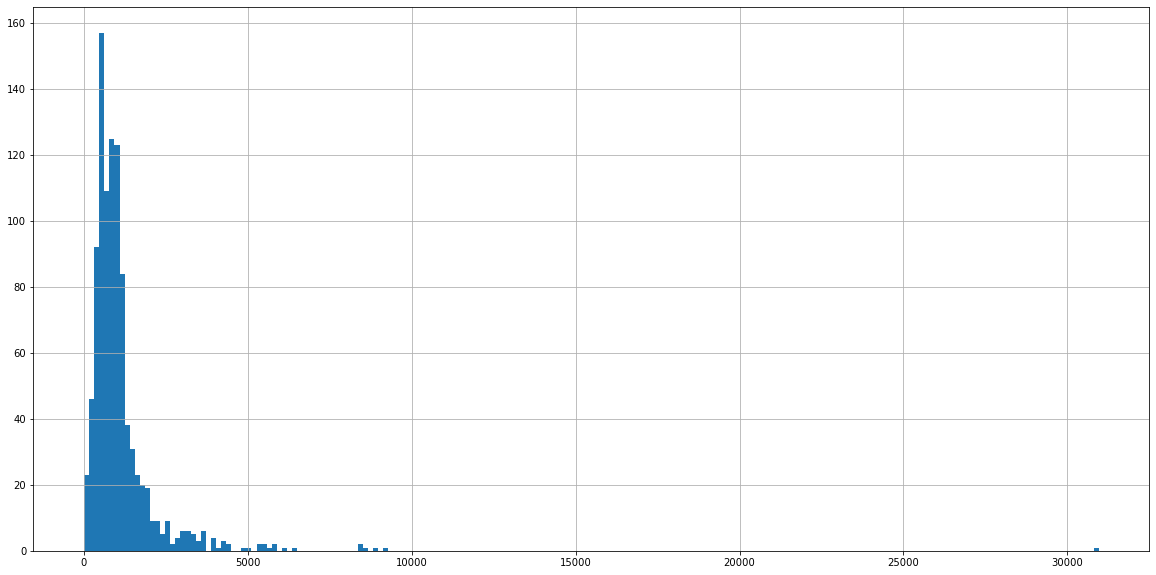

In [8]:
df_all['num_words'].hist(figsize=(20,10), bins=200)

*Observations:* Most of the documents are less than 3,000 words, though there is 1 outlier at > 30,000 words. Next, let's zoom in to look at the distribution among those documents < 3,000 words.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E257167C0>]],
      dtype=object)

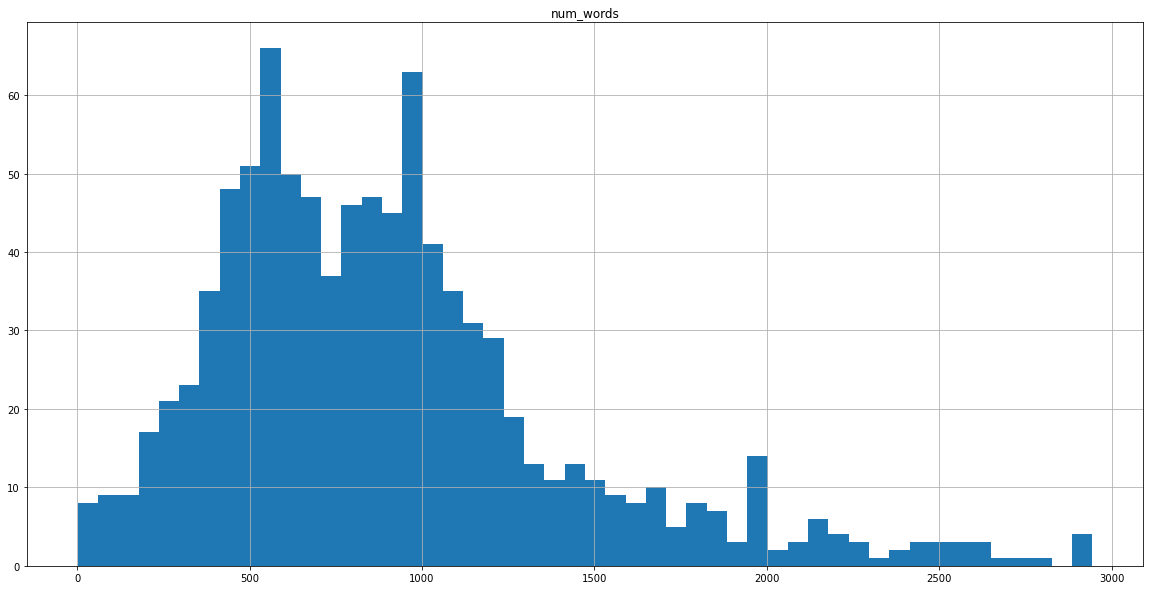

In [9]:
df_all.loc[df_all['num_words']<3000,['num_words']].hist(figsize=(20,10), bins=50)

*Observations:* documents of length 500-1000 words are the most common. There are some documents with very few words.

Next, let's compare the distributions between class 0 (does not provide evidence of training) and class 1 (provides evidence of training) to see if those that provide evidence tend to be longer.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E258780D0>,
      dtype=object)

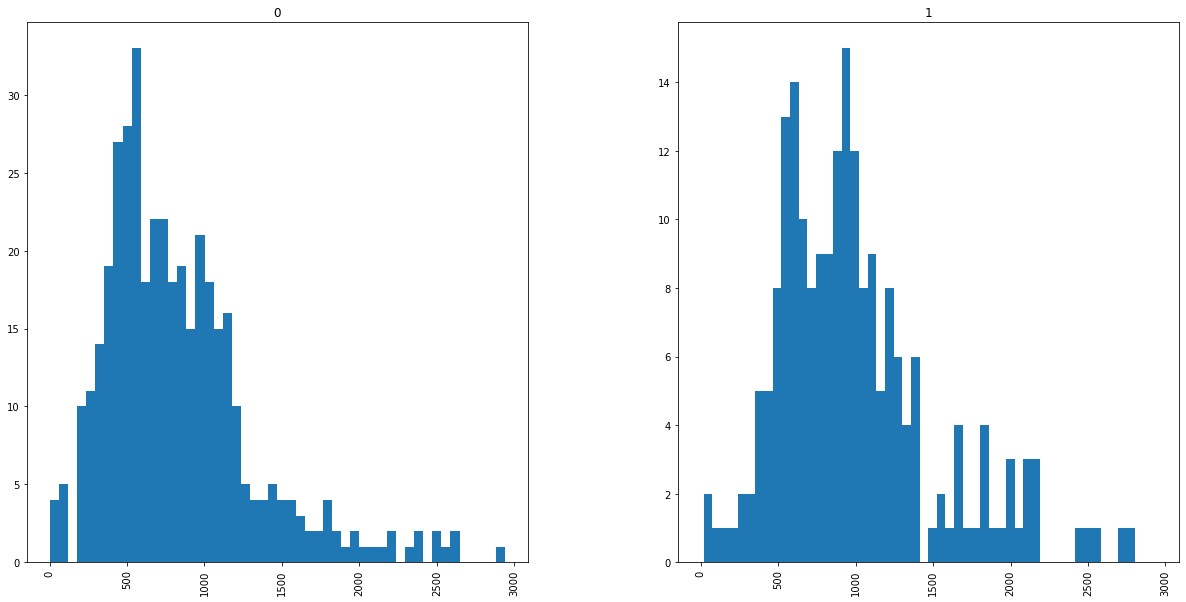

In [10]:
df_labeled.loc[df_labeled['num_words']<3000].hist(column='num_words', 
                                                  by='LABEL_MSA_training_binary', 
                                                  sharex=True, sharey=False, 
                                                  figsize=(20,10), 
                                                  bins=50)

*Observations:* There does not appear to be a significant difference between the two distributions, though there are fewer class 1 than class 0 documents as discovered above.

# Short documents
Many of the documents are very short, even those that have been labeled with class 1 (document provides evidence of modern slavery training). Let's look at those short class 1 documents to see what kind of evidence can be provided in such short documents.

In [11]:
questionable = df_labeled.loc[(df_labeled['num_words']<400) & 
                              (df_labeled['LABEL_MSA_training_binary']==1)].sort_values('num_words')
questionable

,TEXT,LABEL_MSA_training_binary,LABEL_MSA_training_original,source,split,num_words
ID,,,,,,
366,Modern Slavery Statement for Financial Year 20...,1,"Recruitment / HR, Employees (all)",labeled,"[Modern, Slavery, Statement, for, Financial, Y...",19
46,Arcadia Group Ltd\nModern Slavery Act – Transp...,1,"Suppliers, Employees (all)",labeled,"[Arcadia, Group, Ltd, Modern, Slavery, Act, –,...",66
67,Anti-Slavery and Human Traffic Statement\nAnti...,1,"Procurement / purchasing, Leadership, Employ...",labeled,"[Anti-Slavery, and, Human, Traffic, Statement,...",123
583,KURT GEIGER\n\nMenu\nKURT GEIGER\n\nSearch\n\n...,1,Employees (all),labeled,"[KURT, GEIGER, Menu, KURT, GEIGER, Search, KUR...",141
476,dyson\nUK Modern Slavery Act Statement\nDyson ...,1,Recruitment / HR,labeled,"[dyson, UK, Modern, Slavery, Act, Statement, D...",232
27,California Transparency in Supply Chains Act (...,1,"Procurement / purchasing, Employees (all)",labeled,"[California, Transparency, in, Supply, Chains,...",280
523,"Modern Slavery Act 2015 (""MSA"")\nAldermore Sla...",1,Suppliers,labeled,"[Modern, Slavery, Act, 2015, (""MSA""), Aldermor...",294
34,Hasbro\nAs part of our commitment to corporate...,1,"Leadership, Suppliers, Employees (all)",labeled,"[Hasbro, As, part, of, our, commitment, to, co...",317
232,and\nModern slavery and human trafficking stat...,1,Leadership,labeled,"[and, Modern, slavery, and, human, trafficking...",343


In [12]:
for i, row in questionable.iterrows():
    num_words=row["num_words"]
    print(80*'-')
    print(f'df_labeled document id {i} has {num_words} words:')
    print(80*'-')
    print(row['TEXT'])
    print(2*'\n')

--------------------------------------------------------------------------------
df_labeled document id 366 has 19 words:
--------------------------------------------------------------------------------
Modern Slavery Statement for Financial Year 2016/17
Our business Our policies
Our suppliers
Approval for this statement Simon Fuller





--------------------------------------------------------------------------------
df_labeled document id 46 has 66 words:
--------------------------------------------------------------------------------
Arcadia Group Ltd
Modern Slavery Act – Transparency Statement
Modern Slavery Statement
September 2016 - August 2017
Read here
Modern Slavery Statement
September 2015 - August 2016
Read here
© Arcadia Group Limited • Accessibility • Modern Slavery Act • Candidate Privacy • Legal Notice • Privacy Notice • CA Transparency Act • Contacts
This site uses cookies. Details of which can be found here. Accept





-----------------------------------------------

*Observations from the the 11 documents reviewed in the previous cell:* 

Doc ids 366, 46, 67, and 583 are all extremely short and contain no references to training at all. They do however look like there is important information missing. 366 and 46 look like only the section headers made it through. Doc ids 46, 67, and 583 appear to be scraped from websites, but the relevant content is missing. Perhaps there was an issue with the scraper. It looks like these sites may link to the actual statements, but those linked documents have not made it to this database. There could be an issue with the pipeline, or perhaps these statements were mislabeled for some other reason.

Doc ids 523 and 34 appear to be complete statements, unlike the previously mentioned docs. However, they make no mention of training, so are likely mislabeled.

These documents *do* contain information about training and appear to be properly labeled:
 - doc id 476: "...Dyson has a dedicated Corporate Social Responsibility (CSR) team that works with suppliers through a combination of assessments using ethical database Sedex, supplier training and audits..."
 - doc id 27: "...Tiffany & Co. supply chain management has received training in our Social Accountability Program, which includes mitigating risks of human trafficking and slavery within our supply chain..."
 - doc id 232: "...Requiring all Managers to have completed training on modern slavery by 30th November..."
 - doc id 64: "...We have raised awareness amongst all our employees; both our Anti-Slavery & Human Trafficking and our Anti-Corruption & Open Door (Whistleblowing) policy are included as specific topics in the induction training for all employees..."
 - doc id 100: "...Our Compliance Teams have been externally trained in the exploitation of human labour and we have received training in the Stronger Together principles..."

**Of 11 documents investigated, less than half appear to be properly labeled!** Of the 6 mislabeled, 4 could be issues with the data pipeline, but 2 appear to be completely wrong. This sample may not be representative of the rest of the dataset as it is only the shortest statements, so next we will look at a random sampling of 10 of the remaining class 1 statements to see how many appear improperly labeled.

(Additionally, looking through the statements it is apparent that the text formatting is not uniform among the documents with respect to line breaks. Some docs have line breaks in the middle of sentences (e.g. doc 64) whereas others only have line breaks at the end of paragraphs. This will likely need to be addressed in data cleaning.)

In [13]:
sample = df_labeled.loc[(df_labeled['num_words']>=400) & 
                        (df_labeled['LABEL_MSA_training_binary']==1)].sample(n=10, replace=False, random_state=42)
for i, row in sample.iterrows():
    num_words=row["num_words"]
    print(80*'-')
    print(f'df_labeled document id {i} has {num_words} words:')
    print(80*'-')
    print(row['TEXT'])
    print(2*'\n')

--------------------------------------------------------------------------------
df_labeled document id 452 has 988 words:
--------------------------------------------------------------------------------
STORES

HELP

More 

Smart Rewards My Account

Anti-Slavery and human trafficking statement

At Clinique, we respect the human rights of our employees, suppliers and the communities in which we operate. We are committed to upholding the principles contained in the United Nations Universal Declaration of Human Rights and the UK Modern Slavery Act 2015.
By law, companies like ours in the UK are required to disclose publicly the steps we are taking to identify and eradicate forced labour and human trafficking from our supply chains. We are part of a multinational group of companies that operates around the world. The following describes the efforts of our group, including in the UK:
Verification

We require our suppliers to operate in compliance with all applicable laws, including laws p

Seven of these ten documents *do* contain information about training and appear to be properly labeled:
 - doc id 452: "...Since the publication of last year’s anti-slavery and human trafficking statement, we have taken the following further steps to tackle forced labour and human trafficking...Provided additional training on our Supplier Code of Conduct to select Clinique employees responsible for engaging with suppliers...."
 - doc id 644: "...RBA’s Learning Academy provides online trainings on a range of topics, including methods to combat trafficked and forced labor in the supply chain..."
 - doc id 645: "...Seasalt team members regularly visit our suppliers to review and audit their factories, working conditions and employees directly. Seasalt team members are provided with appropriate training internally to ensure they are able to address issues when with the suppliers..."
 - doc id 307: "...Adobe encourages suppliers to utilize EICC's Learning Academy which contains online learning modules that cover the EICC Code of Conduct..." and earlier in the document: "...Adobe commits publicly to the EICC Code of Conduct (Code)...We evaluate and address risks of human trafficking and slavery through conformance to the Code, Section A.1, which states, among other standards, that: Forced, bonded (including debt bondage) or indentured labor, involuntary prison labor, slavery or trafficking of persons shall not be used..."
 - doc id 510: "...TRAINING AND RESPONSIBILITY The Board and Senior Management have responsibility for implementing this policy statement and ensuring that any employee, in particular those who have direct responsibility for the supply chain, has adequate resources to ensure that slavery and human trafficking is not taking place within the organisation and within its supply chain..."
 - doc id 626: "...We’ve completed three years’ worth of training which in the first two years focused on building awareness within our Senior Management, Procurement and People teams, and Speak Up whistle-blowing line officers around the world of what human trafficking and modern slavery is and the various responsibilities these teams have for monitoring compliance with our policies and reporting concerns...."
 - doc id 420: "...We have been taking pro-active steps with respect to our procurement processes and our supply chains to ensure that suppliers self-certify that they do not endorse, enable or facilitate human trafficking or slavery within their business and work is on-going to build the self-certification requirement into our procurement process. Ethical procurement training has been completed by procurement staff in the UK...."
 
Of the remaining three documents, all three are ambiguous whether they should be class 0 or class 1. Two appear to be missing text that may have cleared up these ambiguities.
- doc id 275 contains only one mention of training: "...Destinology's employees have to complete the same mandatory training as Saga employees...." This does not seem specific enough to justify a class 1 assignment. However there appears to be an incomplete sentence following this one, "In addition, Destinology is included within Saga's wider audit and compliance activity to ensure we comply with both the law and" which may indicate there was some text lost that could have described the training in more detail. It is possibly misclassified?
- doc id 59 contains only one mention of training: "...The business has provided training to key managers in social compliance requirements..." but this is not clear whether the training is anti-slavery related (social compliance requirements are not defined elsewhere in the document), though it likely is. This is debatable whether it should be assigned class 1 or 0.
- doc id 243 does not mention training. It may be this portion that could be interpreted as implying training: "...all Lenovo employees are required to certify awareness and compliance with our Employee Code of Conduct...As part of its Employee Code, Lenovo explicitly prohibits the use of child labor and forced labor..." though that does not seem sufficient to indicate training. It also appears that there is a portion of this document missing as the last sentence ends abruptly: "...Supplier accountability of the program is achieved through a formal management system which includes standardized monthly reporting to senior procurement management based on specific key performance indicators. Specifically we measure:" It may be that the relevant portion of the document was contained in this missing portion.

Given that there appear to be data quality issues with 30%+ of the class 1 documents, this dataset should be considered very noisy. It is likely that it is too noisy in its current state with only 650 labeled documents to be able to train a reliable machine learning classifier. Either the data quality needs to be addressed or many more labeled documents are likely needed.

# Mentions of training in class 0 docs
let's explore to see if any class 0 documents contain the string "train" to see what types of documents are likely to be misclassified

In [14]:
df_class0 = df_labeled.loc[(df_labeled['LABEL_MSA_training_binary']==0)]

train0_ids=[]
for i, row in df_class0.iterrows():
    if 'train' in str(row['TEXT']):
        train0_ids.append(i)
len(train0_ids)/df_class0.shape[0]

0.7047619047619048

*Observations:* 70% of the class 0 documents contain the string "train". This is higher than expected. How many contain the string "training"?

In [15]:
training0_ids=[]
for i, row in df_class0.iterrows():
    if 'training' in str(row['TEXT']):
        training0_ids.append(i)
len(training0_ids)/df_class0.shape[0]

0.6857142857142857

*Observations:* nearly the same amount contain "training". Let's take a look at a few of the shorter ones to see how the word training is being used:

In [16]:
df_class0_w_training = df_class0.loc[training0_ids].sort_values('num_words')
df_class0_w_training.head(10)

,TEXT,LABEL_MSA_training_binary,LABEL_MSA_training_original,source,split,num_words
ID,,,,,,
116,Hastings Hotels Group MODERN SLAVERY ACT TRANS...,0,In Development,labeled,"[Hastings, Hotels, Group, MODERN, SLAVERY, ACT...",202
93,DEBOLD\nCalifornia Transparency in Supply\nCha...,0,In Development,labeled,"[DEBOLD, California, Transparency, in, Supply,...",232
168,Arcus Infrastructure Partners LLP Modern Slave...,0,Training provided - not specified,labeled,"[Arcus, Infrastructure, Partners, LLP, Modern,...",235
42,"HK\nHANWA CO., LTD\nThis statement is made pur...",0,Training provided - not specified,labeled,"[HK, HANWA, CO.,, LTD, This, statement, is, ma...",251
513, MENU\nModern Slavery Statement\nGelder Group...,0,Training provided - not specified,labeled,"[, MENU, Modern, Slavery, Statement, Gelder, ...",256
473,Statement on Slavery and Human Trafficking 201...,0,"Employees (all), Training provided - not spec...",labeled,"[Statement, on, Slavery, and, Human, Trafficki...",276
589,Anti-Slavery and Human Trafficking Statement L...,0,Training provided - not specified,labeled,"[Anti-Slavery, and, Human, Trafficking, Statem...",278
328,Missguided Modern Slavery Statement 2015/2016\...,0,"Training provided - not specified, In Develop...",labeled,"[Missguided, Modern, Slavery, Statement, 2015/...",280
274,We use cookies to personalize and enhance your...,0,Training provided - not specified,labeled,"[We, use, cookies, to, personalize, and, enhan...",299


*Observations:* Looking at the 'LABEL_MSA_training_original' column, it appears most of these documents discuss training that is either in development and hasn't been implemented yet, or training that has not been specified in sufficient detail to warrant a class 1 label. Let's take a closer look at the actual text for these docs:

In [17]:
for i in range(10):
    print(80*'-')
    print(f'df_labeled document id {df_class0_w_training.iloc[i].name} has {df_class0_w_training.iloc[i]["num_words"]} words:')
    print(80*'-')
    print(df_class0_w_training.iloc[i]['TEXT'])
    print(2*'\n')

--------------------------------------------------------------------------------
df_labeled document id 116 has 202 words:
--------------------------------------------------------------------------------
Hastings Hotels Group MODERN SLAVERY ACT TRANSPARENCY STATEMENT
INTRODUCTION
The Modern Slavery Act 2015 creates offences in respect of slavery, servitude, forced or compulsory labour and human trafficking ("Modern Slavery"). Hastings Hotels are committed to combatting all forms of Modern Slavery.
ABOUT HASTINGS HOTELS
The group consists of over 7 hotels and resorts in Northern Ireland. The business relies on the services of around 1,000 workers.
Hastings Hotels recognises that Modern Slavery is not an issue confined to the overseas hospitality sector. In particular we recognise the risks that arise from the use of foreign and migrant labour, and from supply chains both in the UK and overseas.
POLICIES AND PROCEDURES
In the financial year, the existing policies and procedures of Hastin

*Observations:*
Some of these documents refer to plans to add training in the future:
- doc id 116: "...In the coming months, Hastings Hotels intends to take additional steps including:...Modern Slavery training across the wider group."
- doc id 93: "...Diebold intends to, but does not currently, provide training on human trafficking and modern slavery to employees and management who have direct responsibility for the supply chain."
- doc id 574: "...The Company Directors and Senior Management shall take responsibility for implementing this policy statement and its objectives and shall provide adequate resources (training etc.) and investment to ensure that slavery and human trafficking is not taking place within the organisation and its' supply chains..."

One of these documents discuss training but it is not clear whether the training contains any anti-slavery content:
- doc id 589: "...Annual training is provided on the importance of ethical conduct..."

However, most of these documents seem to be misclassified and should be classified as class 1 unless there is some other criteria that I am unaware of:
- doc id 168: "...This is Arcus Infrastructure Partners LLP’s statement on slavery and human trafficking in response to section 54 of the Modern Slavery Act 2015 (the “Act”)...Staff receive annual compliance training which includes details on the Act..."
- doc id 42: "...We are providing appropriate training about modern slavery and human trafficking to relevant members of staff to ensure a high level of understanding of the risks of it in our supply chains and our business..."
- doc id 513: "...Our commitment is to:...Provide training for all employees who are involved in the supply chain on issues relating to slavery and human trafficking..."
- doc id 473: "...In order to raise awareness of slavery and human trafficking, WD Meats has incorporated slavery and human trafficking awareness training into our regular training curriculum for employees and management..."
- doc id 328: "...To ensure a high level of understanding of the risks of Modern Slavery in our supply chains and in our business we provide guidance, training and assistance to our staff and suppliers..."
- doc id 274: "...At least once a year, Wabtec includes training on compliance with human trafficking and slavery laws and regulations as part of its monthly meeting of Purchasing Managers..."

# Conclusions and Recommendations

- Many of the documents appear to be missing text. The pipeline should be evaluated to make sure that all of the text used to assign the labels is making it through properly.
- Many of the documents in both classes appear to be mislabeled. Is it possible that the labels and text somehow got shuffled somewhere along the pipeline such that the text no longer lines up with the original labels?
- The data is quite inconsistent in punctuation formatting, especially with respect to line breaks. These may need to be cleaned up depending on the algorithmic approach.
- Given the number of mislabeled documents and the small quantity of labeled documents in the first place, it is unlikely we can train a good-performance machine learning classifier with the data as is. Perhaps an approach should be developed that could ignore the labels and generate its own class predictions more accurately based on a pre-trained model (Zero- or few-shot learning). One possibility is an extractive question answering model (e.g. a SQuAD2.0-trained model).